In [76]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import root
import scipy.signal
from dde import ddeint
import seaborn as sns
sns.set_context('paper', font_scale=1.3)
red, blue, green = sns.color_palette('Set1', 3)
from rakott.mpl import fig_xlabel, fig_ylabel

# Deterministic discrete SIR model

$$
S_{t+1} = S_t - b_t S_t I_t \\
I_{t+1} = I_t + b_t S_t I_t - \gamma I_t  \\
R_{t+1} = R_t + \gamma I_t \\
b_t = b_0 c^*_t \quad (2.4) \\
c^*_t = \hat{c} - \alpha \frac{I_{(t-\Delta)}}{N} \quad (2.10)
$$

In [77]:
N = 10000
I0 = 1
b0 = 0.05
γ = 0.08
c_hat = 0.0015
α1 = 0.02
α2 = 0.3
Δ = 3

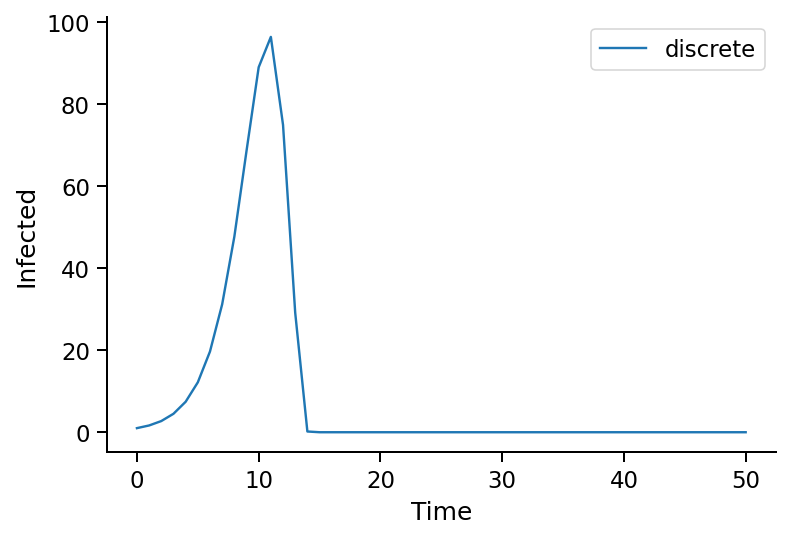

In [78]:
def I2(N, b0, γ, c_hat, α1, α2):
    α = α2 / (2 * α1) * b0
    numer = α + c_hat - np.sqrt(α * α + c_hat * c_hat - 2 * α * c_hat + 4 * α * γ / (b0 * N))
    res = numer / (2 * α / N)
    if res < 0: return np.nan
    return res

def f(St, It, IΔ, N, b0, γ, c_hat, α1, α2, min0=False, maxN=False):
    Rt = N - St - It
    α = α2 / (2 * α1) * b0
    ct = c_hat - α * IΔ / N
    bt = b0 * ct
    infected = bt * St * It
    recovered = γ * It
    St1 = St - infected
    It1 = It + infected - recovered
    St1 = np.array(St1)
    It1 = np.array(It1)
    if min0: 
        St1[St1 < 0] = 0
        It1[It1 < 0] = 0
    if maxN: 
        St1[St1 > N] = N
        It1[It1 > N] = N
    return St1, It1

def det_dis_simulation(I0, N, b0, γ, c_hat, α1, α2, Δ, tmax=500, min0=False, maxN=False):
    S = np.zeros(tmax+1)
    S[0] = N - I0
    I = np.zeros(tmax+1)
    I[0] = I0
    for t in range(tmax):
        IΔ = I[t-Δ] if t >= Δ else I0
        S[t+1], I[t+1] = f(S[t], I[t], IΔ, N, b0, γ, c_hat, α1, α2, min0, maxN)
    return S, I

S, I = det_dis_simulation(I0, N, b0, γ, c_hat, α1, α2, Δ, tmax=50, min0=True, maxN=True)
plt.plot(I, label='discrete')
plt.xlabel('Time')
plt.ylabel('Infected')
plt.legend()
sns.despine()

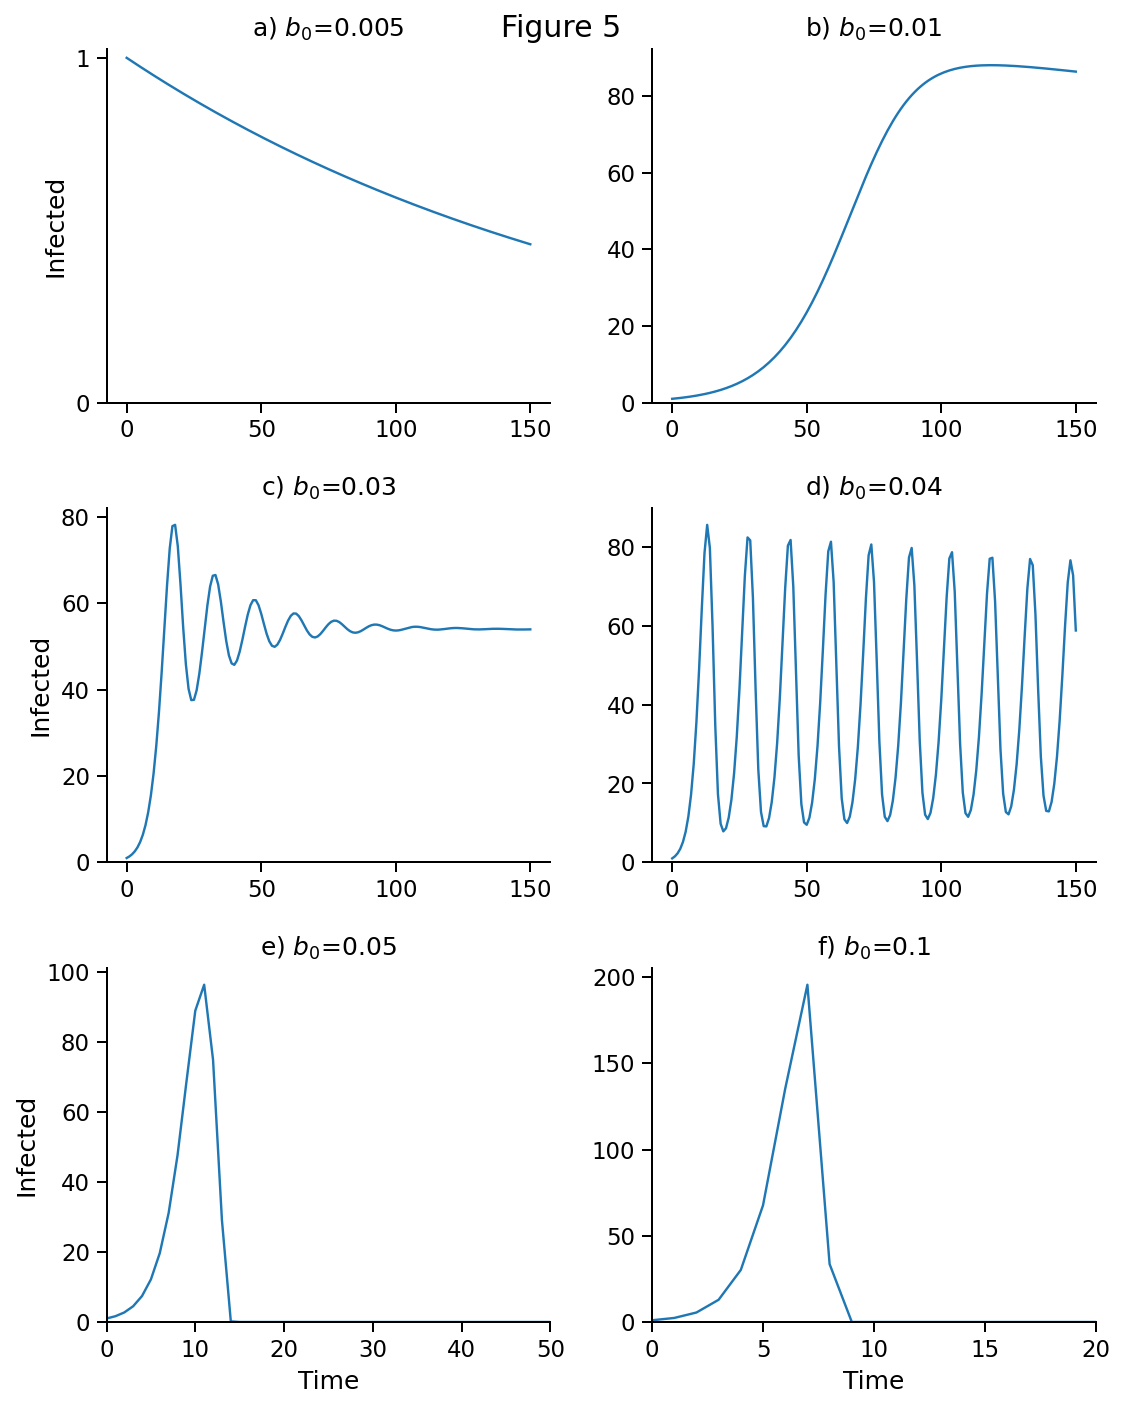

In [53]:
b0s = [0.005, 0.01, 0.03, 0.04, 0.05, 0.1]

fig, axes = plt.subplots(3, 2, figsize=(8, 10))
for b0_, ax, label in zip(b0s, axes.flat, 'abcdef'):
    S, I = det_dis_simulation(I0, N, b0_, γ, c_hat, α1, α2, Δ, tmax=150, min0=True, maxN=True)
    ax.plot(I)
    ax.set_ylim(0, None)        
    ax.set_title("{}) $b_0$={}".format(label, b0_))
for ax in axes[:,0]: ax.set_ylabel('Infected')
for ax in axes[2]: ax.set_xlabel('Time')
axes[2,0].set_xlim(0, 50)
axes[2,1].set_xlim(0, 20)
axes[0,0].set_yticks([0, 1])
# axes[-1,-1].set_ylim(0, max(Icont.max(), Idis.max()))
fig.suptitle('Figure 5')
fig.tight_layout()
sns.despine()
plt.savefig('../figures/fig5-SIR.pdf', dpi=100)

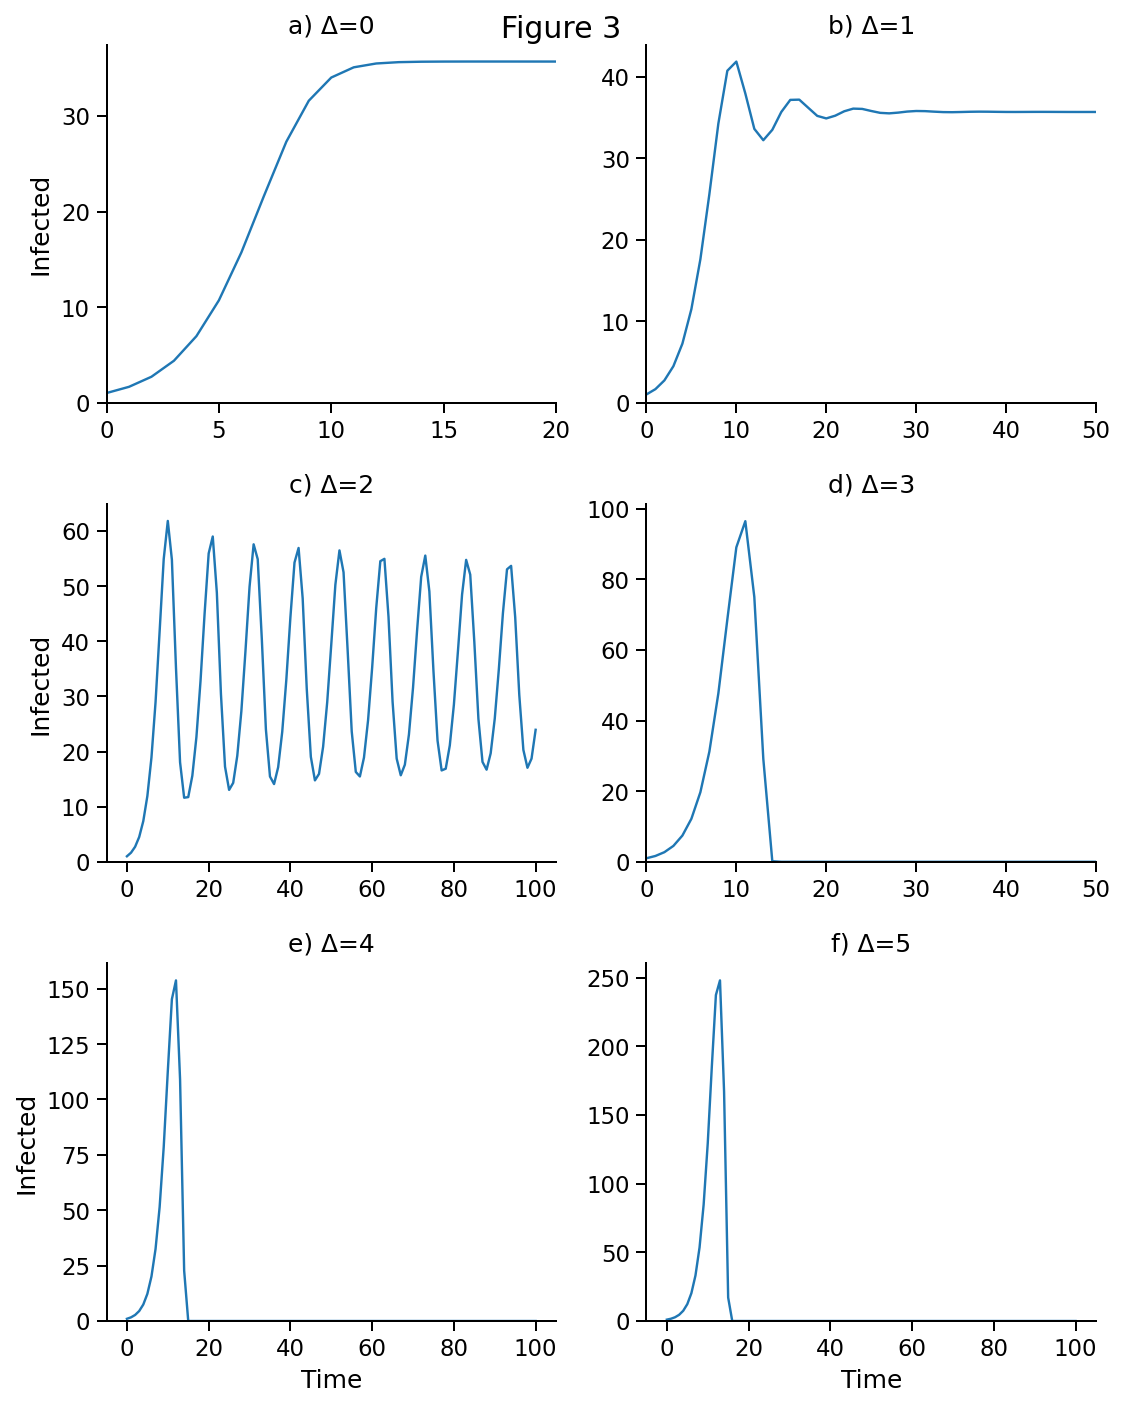

In [54]:
Δs = [0, 1, 2, 3, 4, 5]

fig, axes = plt.subplots(3, 2, figsize=(8, 3.33*3))
for Δ_, ax, label, I in zip(Δs, axes.flat, 'abcdef', results_Δs):
    S, I = det_dis_simulation(I0, N, b0, γ, c_hat, α1, α2, Δ_, tmax=100, min0=True, maxN=True)
    ax.plot(I)
    ax.set_ylim(0, None)
    ax.set_title("{}) Δ={}".format(label, Δ_))
axes[0,0].set_xlim(0, 20)
axes[0,1].set_xlim(0, 50)
axes[1,1].set_xlim(0, 50)
for ax in axes[:,0]: ax.set_ylabel('Infected')
for ax in axes[2]: ax.set_xlabel('Time')
fig.suptitle('Figure 3')
fig.tight_layout()
sns.despine()
plt.savefig('../figures/fig3-SIR.pdf', dpi=100)

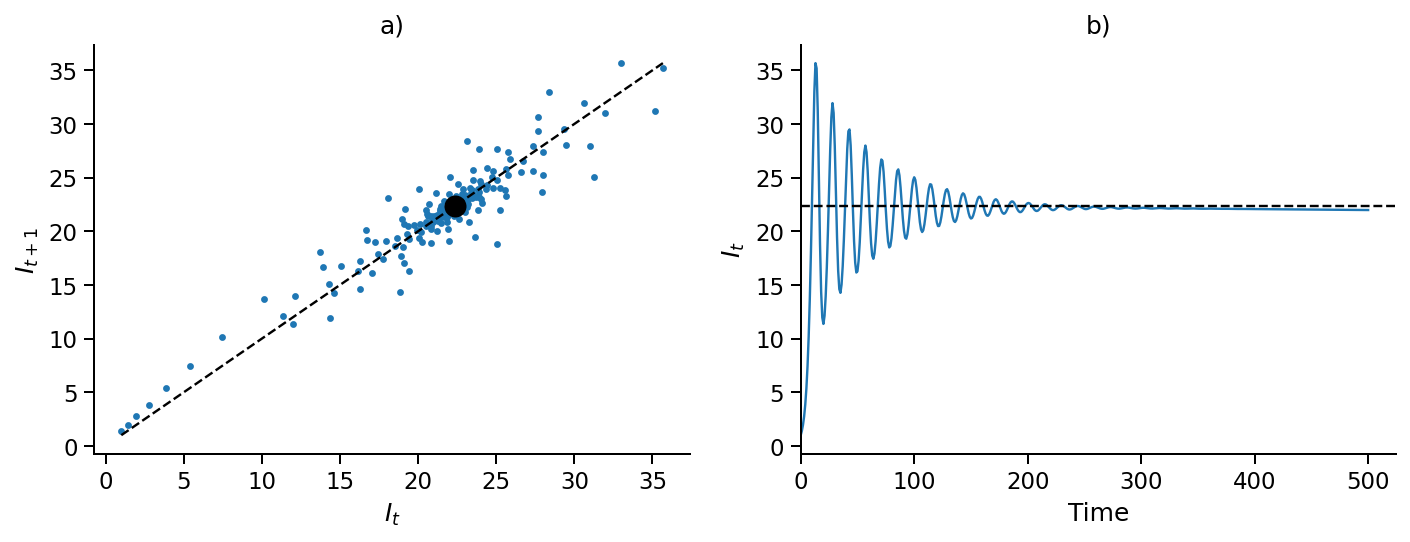

In [43]:
c_hat_ = 0.001

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes[0]
S, I = det_dis_simulation(I0, N, b0, γ, c_hat_, α1, α2, Δ)
ax.plot(I[:-1], I[1:], '.')
axes[1].plot(I)
line = np.linspace(I.min(), I.max())
ax.plot(line, line, ls='--', color='k')
ax.plot(I2(N, b0, γ, c_hat_, α1, α2), I2(N, b0, γ, c_hat_, α1, α2), 'o', color='k', markersize=10)
ax.set_xlabel('$I_t$')
ax.set_ylabel('$I_{t+1}$')

ax = axes[1]
ax.axhline(I2(N, b0, γ, c_hat_, α1, α2), ls='--', color='k')
ax.set(xlabel='Time', ylabel='$I_t$', xlim=(0, None))

# ax.set_title('Figure X)
for ax, label in zip(axes.flat, 'abcd'): ax.set_title("{})".format(label))
sns.despine()
fig.tight_layout()
# fig.savefig('../figures/figX-SIR.pdf')

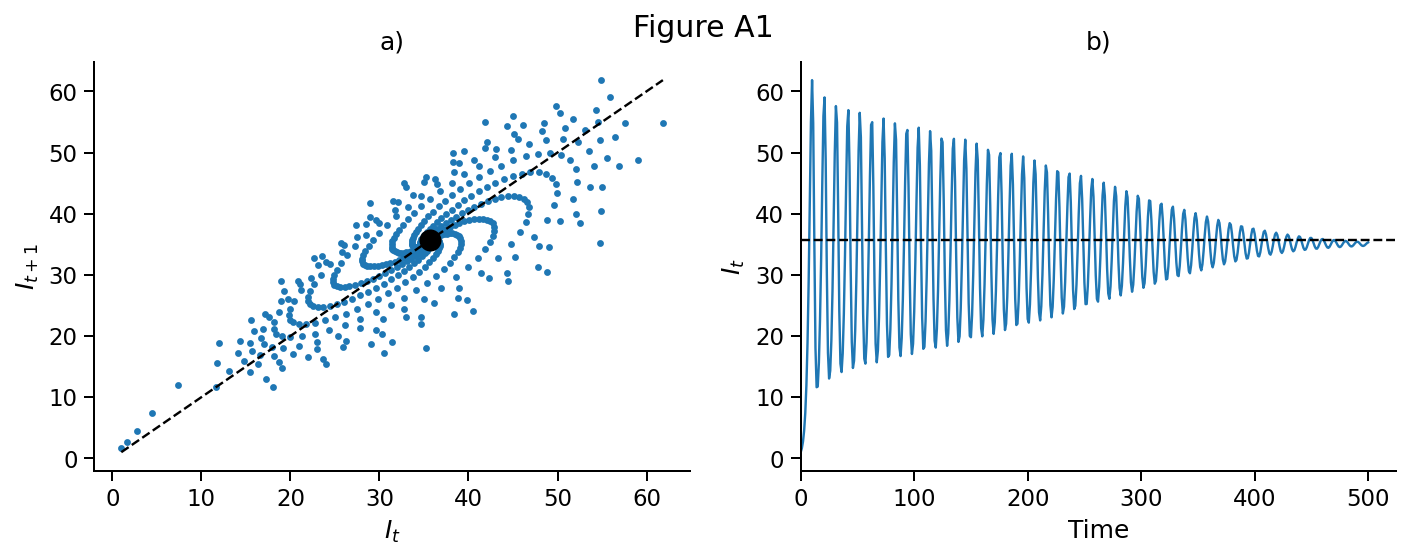

In [80]:
Δ_ = 2

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes[0]
S, I = det_dis_simulation(I0, N, b0, γ, c_hat, α1, α2, Δ_)
ax.plot(I[:-1], I[1:], '.')
line = np.linspace(I.min(), I.max())
ax.plot(line, line, ls='--', color='k')
ax.plot(I2(N, b0, γ, c_hat, α1, α2), I2(N, b0, γ, c_hat, α1, α2), 'o', color='k', markersize=10)
ax.set_xlabel('$I_t$')
ax.set_ylabel('$I_{t+1}$')

ax = axes[1]
ax.plot(I)
ax.axhline(I2(N, b0, γ, c_hat, α1, α2), ls='--', color='k')
ax.set(xlabel='Time', ylabel='$I_t$', xlim=(0, None))

fig.suptitle('Figure A1')
for ax, label in zip(axes.flat, 'abcd'): ax.set_title("{})".format(label))

sns.despine()
fig.tight_layout()
fig.savefig('../figures/figA1-SIR.pdf')

# Table 1: Δ=3, b0 varies

In [56]:
N=10000
I0=1
b0s=[0.005, 0.01, 0.03, 0.04, 0.05]
γ=0.08
c_hat=0.0015
α1=0.02
α2=0.3 
Δ=3

classifications = ['Mon. convergence to I0', 'Mon. convergence to I2', 'Damped oscillation to I2', 'Perpetual oscillation', 'Collapse']

In [57]:
results_table1 = []
for b0_ in b0s:
    S, I = det_dis_simulation(I0, N, b0_, γ, c_hat, α1, α2, Δ, tmax=250, min0=True, maxN=True)
    results_table1.append(I)

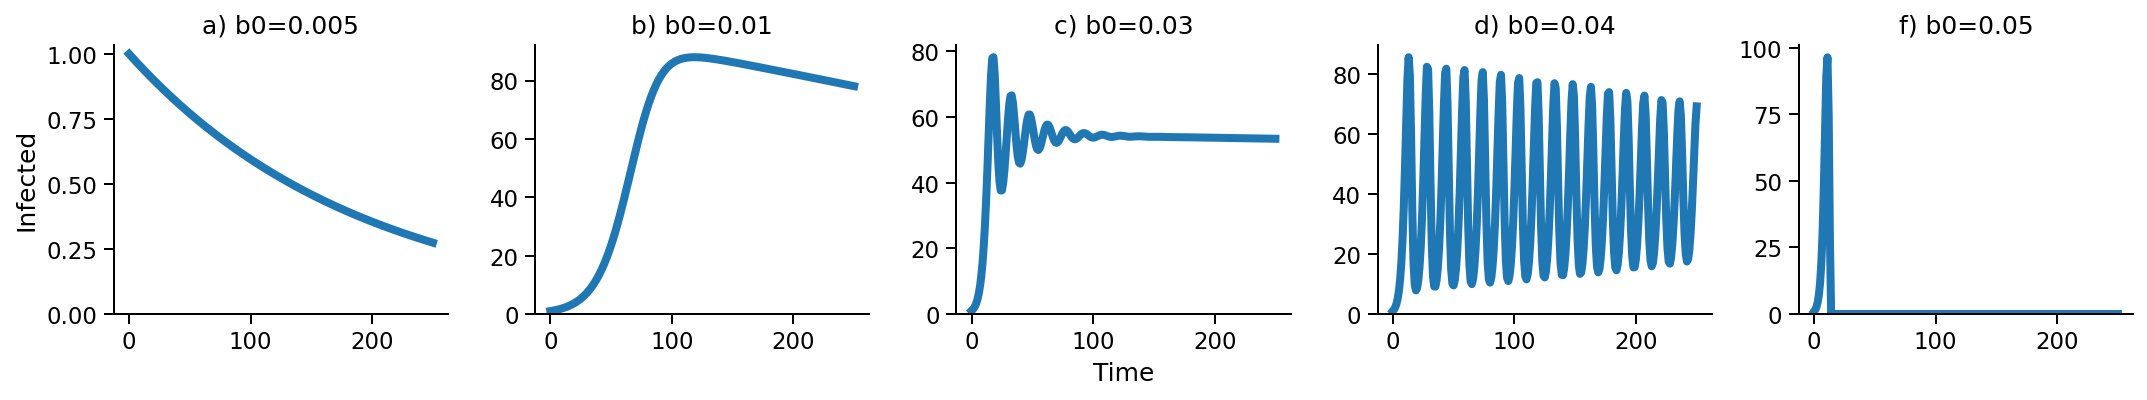

In [58]:
fig, axes = plt.subplots(1, len(b0s), figsize=(15, 3), sharex=True)
for label, ax, b0_, res, classif in zip('abcdfef', axes.flat, b0s, results_table1, classifications):
#     I1_ = I1(N, b0_, γ, c_hat, α1, α2)
#     I2_ = I2(N, b0_, γ, c_hat, α1, α2)
#     print('b0={:12}\tI1={:12.2f}\tI2={:12.2f}'.format(b0_, I1_, I2_))
    I = res
    ax.plot(I, lw=4)
#     ax.plot(t, Icont, '-', lw=2)    
#     ax.axhline(I2_, color='k')
    ax.set(ylim=(0, None), title='{}) b0={}'.format(label, b0_))
axes[2].set(xlabel='Time')
axes[0].set(ylabel='Infected')
fig.tight_layout()
sns.despine()
# fig.savefig('../figures/figX.pdf', dpi=100)

# Table 2: Δ = 3, γ varies

In [60]:
N=10000
I0=1
b0=0.05
γs=[0.1,0.2,0.45,0.65,0.75]
c_hat=0.0015
α1=0.02
α2=0.3 
Δ=3

classifications = ['Collapse', 'Perpetual oscillation', 'Damped oscillation to I2', 'Mon. convergence to I2', 'Mon. convergence to I0']

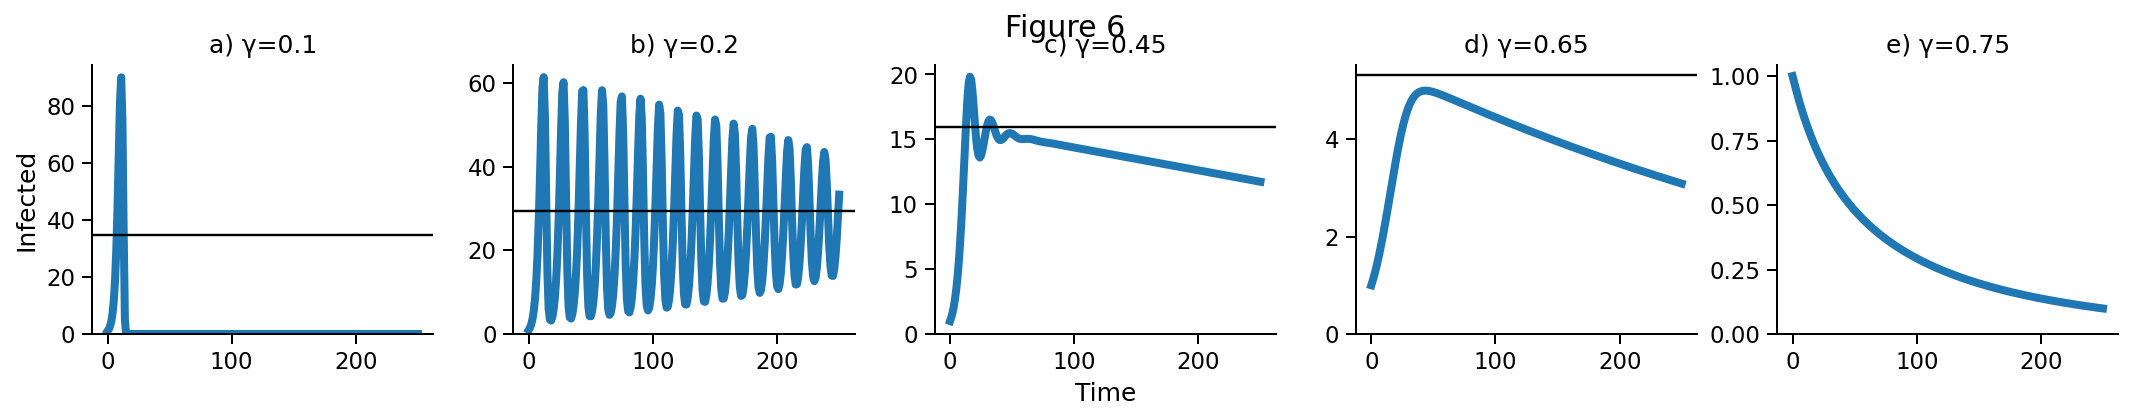

In [66]:
fig, axes = plt.subplots(1, len(γs), figsize=(15, 3), sharex=True)
for label, ax, γ_, classif in zip('abcdef', axes.flat, γs, classifications):
    S, I = det_dis_simulation(I0, N, b0, γ_, c_hat, α1, α2, Δ, tmax=250, min0=True, maxN=True)
    ax.plot(I, lw=4)
    ax.axhline(I2(N, b0, γ_, c_hat, α1, α2), color='k')
    ax.set(ylim=(0, None), title='{}) γ={}'.format(label, γ_))
axes[2].set(xlabel='Time')
axes[0].set(ylabel='Infected')
fig.suptitle('Figure 6\n')
fig.tight_layout()
sns.despine()
fig.savefig('../figures/fig6-SIR.pdf', dpi=100)

# Table 3: Δ shift

In [94]:
N=10000
I0=1
b0=0.05
γ=0.08
c_hat=0.0015
α1=0.02
α2=0.3 
Δs=0,1,2,3,4

classifications = ['Mon. convergence to I2', 'Damped oscillation to I2', 'Perpetual oscillation', 'Collapse', 'Collapse']

In [22]:
results_table3 = []
for Δ_ in Δs:
    Idis = det_dis_simulation(I0, N, b0, γ, c_hat, α1, α2, Δ_, tmax=250, min0=True, maxN=True)
    t, Icont = det_cont_simulation(I0, N, b0, γ, c_hat, α1, α2, Δ_, tmax=250)
    results_table3.append((Idis, t, Icont))

In [ ]:
fig, axes = plt.subplots(1, len(Δs), figsize=(15, 3), sharex=True)
for label, ax, Δ_, res, classif in zip('abcdef', axes.flat, Δs, results_table3, classifications):
    Idis, t, Icont = res
    ax.plot(Idis, lw=4)
    ax.plot(t, Icont, lw=2)    
    ax.axhline(I2_, color='k')
    ax.set(ylim=(0, None), title='{}) Δ={}'.format(label, Δ_))
#     ax.set(xlabel='Time', ylim=(0, None), title='Δ={}\n{}\n(<1? {})'.format(Δ_, classif, (Icont<1).any()))
axes[2].set(xlabel='Time')
axes[0].set(ylabel='Infected')
fig.tight_layout()
sns.despine()
# fig.savefig('../figures/fig.pdf', dpi=100)

# I0 varies

In [74]:
# I1_ = I1(N, b0, γ, c_hat, α1, α2)
I2_ = I2(N, b0, γ, c_hat, α1, α2)

# print('I1={:.2f}\tdfdI(I1)={:.2f}'.format(I1_, dfdI(I1_, N, b0, γ, c_hat, α1, α2)))
print('I2={:.2f}'.format(I2_))#, dfdI(I2_, N, b0, γ, c_hat, α1, α2)))

I2=35.72


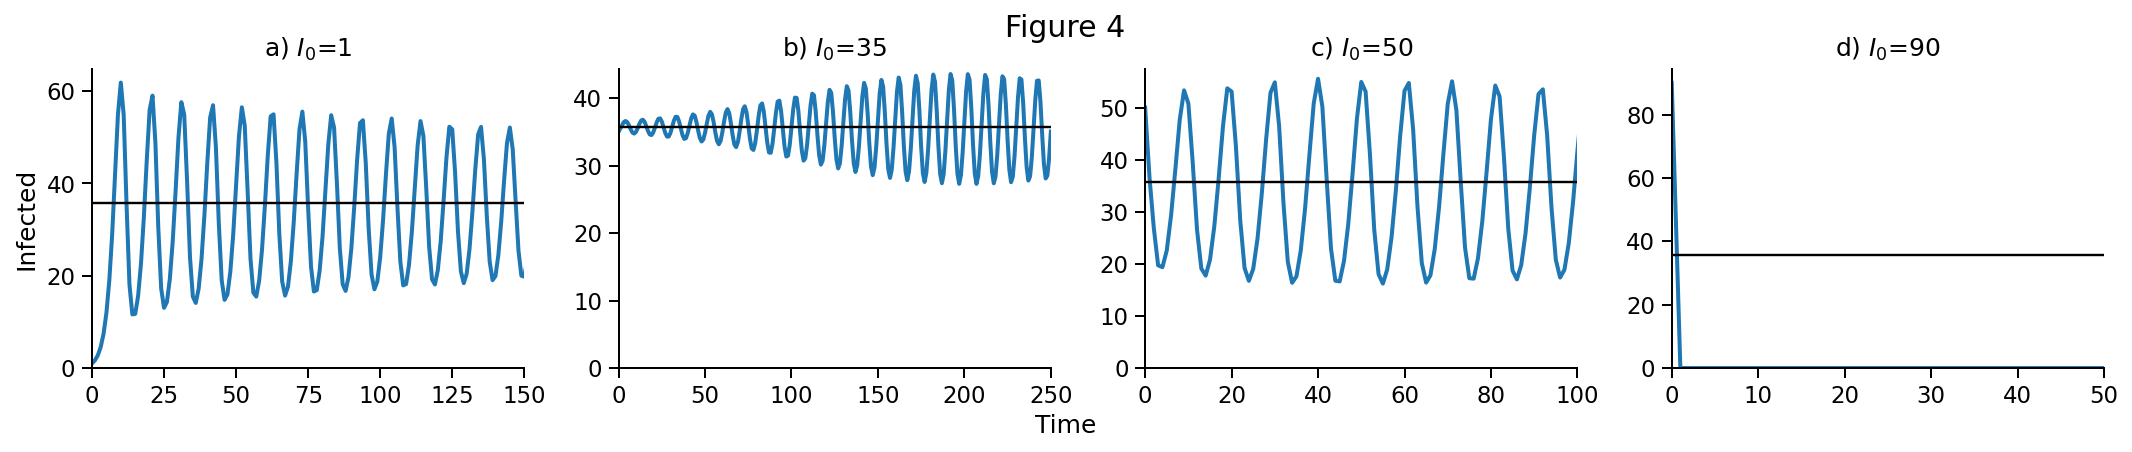

In [75]:
I0s = [1, 35, 50, 90]

fig, axes = plt.subplots(1, len(I0s), figsize=(15, 3))
for label, ax, I0_ in zip('abcdef', axes.flat, I0s):
    S, I = det_dis_simulation(I0_, N, b0, γ, c_hat, α1, α2, Δ=2, tmax=250, min0=True, maxN=True)
    ax.plot(I, lw=2)
    ax.axhline(I2_, color='k')
    ax.set(title='{}) $I_0$={}'.format(label, I0_), ylim=(0, None), xlim=(0, None))
axes[0].set_ylabel('Infected')
fig_xlabel(fig, 'Time')

axes[0].set_xlim(0, 150)
axes[1].set_xlim(0, 250)
axes[2].set_xlim(0, 100)
axes[3].set_xlim(0, 50)

fig.suptitle('Figure 4')
fig.tight_layout()
sns.despine()
fig.savefig('../figures/fig4-SIR.pdf')